## Single scale input vs. Multi-scale input vs. Gated multi-scale input

In [2]:
import os
os.chdir('..')
from glob import glob
from notebooks import config
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.metrics_plot import metrics_plot
from utils.metric import acc_matrix, acc_miou
from utils.raster_vec import vec2mask
from utils.geotif_io import readTiff


### 1. Metric for each test site (only for new method)): miou/oa/prod/user.

In [3]:
path_testsite_wat = glob(config.root_proj + '/data/dset/s1_water_test/*')
path_testsite_wat.sort()
path_testsite_truth = glob(config.root_proj + '/data/dset/s1_truth/*0?_wat*.tif')
path_testsite_truth.sort()


In [29]:
oa, miou, prod, user = [], [], [], []
for idx in range(7):
  truth, truth_info = readTiff(path_testsite_truth[idx])
  wat, wat_info = readTiff(path_testsite_wat[idx])
  oa_i, prod_i, user_i, confus_mat_i = acc_matrix(cla_map=wat, truth_map=truth, id_label=1)
  miou_i = acc_miou(cla_map=wat, truth_map=truth, labels=[1])
  oa.append(float(format(oa_i, '.4f'))), miou.append(float(format(miou_i, '.4f')))
  prod.append(float(format(prod_i, '.4f'))), user.append(float(format(user_i, '.4f')))

oa_m, miou_m = float(format(np.mean(oa), '.4f')), float(format(np.mean(miou), '.4f'))
prod_m, user_m = float(format(np.mean(prod), '.4f')), float(format(np.mean(user), '.4f'))


In [30]:
print('oa:', oa)
print('miou:', miou)
print('prod:', prod)
print('user:', user)
print('oa_m:', oa_m, 'miou_m:', miou_m, 'prod_m:', prod_m, 'user_m:', user_m)



oa: [0.9939, 0.9856, 0.9726, 0.9492, 0.9971, 0.992, 0.9973]
miou: [0.9513, 0.879, 0.9039, 0.4841, 0.9683, 0.9669, 0.9923]
prod: [0.9895, 0.9163, 0.9233, 0.5353, 0.9941, 0.9934, 0.9964]
user: [0.961, 0.9558, 0.9772, 0.8352, 0.9739, 0.9732, 0.9959]
oa_m: 0.984 miou_m: 0.878 prod_m: 0.9069 user_m: 0.9532


### 2. Comparison among methods (plot smoothed metric)

In [35]:
## 1. Model name and the selected metric
model_name = ['model_single_test_1', 'model_scales_test_1', 'model_gscales_test_1']
metric_name = 'val_miou'
path_metrics_1 = config.root_proj + '/model/pretrained/model_single_test/' + model_name[0] + '_metrics.csv'
path_metrics_2 = config.root_proj + '/model/pretrained/model_scales_test/' + model_name[1] + '_metrics.csv'
path_metrics_3 = config.root_proj + '/model/pretrained/model_gscales_test/' + model_name[2] + '_metrics.csv'

## 2. Read metric file (each file corresponding to one model and contains all metrics)
metrics_1 = pd.read_csv(path_metrics_1)
print('metrics_name:',list(metrics_1.columns))
metrics_2 = pd.read_csv(path_metrics_2)
metrics_3 = pd.read_csv(path_metrics_3)

## 3. create new pandas data
metrics_sel = pd.DataFrame({metric_name+'_'+model_name[0]: metrics_1[metric_name], \
                            metric_name+'_'+model_name[1]: metrics_2[metric_name], \
                            metric_name+'_'+model_name[2]: metrics_3[metric_name]})
metrics_sel.tail()


metrics_name: ['tra_loss', 'tra_miou', 'val_loss', 'val_miou']


,val_miou_model_single_test_1,val_miou_model_scales_test_1,val_miou_model_gscales_test_1
195,0.870427,0.909886,0.935863
196,0.878299,0.907606,0.935791
197,0.874500,0.907068,0.935621
198,0.874124,0.907504,0.935504
199,0.879330,0.907847,0.935632


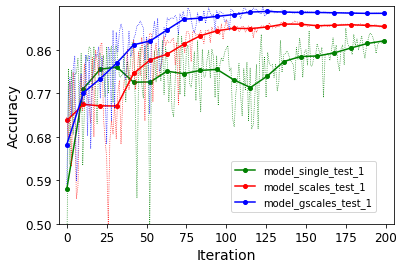

In [62]:
metrics_plot(metrics=metrics_sel, \
              keys=[metric_name+'_'+model_name[0], metric_name+'_' + model_name[1], \
              metric_name + '_' + model_name[2]], \
              colors=['g', 'r', 'b'],  \
              axis_name=['Iteration', 'Accuracy'],\
              axis_range=[[-5,205], [0.5, 0.95]], \
              legend_name=[model_name[0], model_name[1], model_name[2]], \
              legend_pos = [0.50, 0.31],\
              smooth_window =21)
